In [ ]:
!pip install statsmodels


[notice] A new release of pip is available: 23.0.1 -> 23.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
import numpy as np
import pandas as pd
from math import sqrt
from scipy.stats import norm
from matplotlib import pyplot as plt
import seaborn as sns
import plotly
import plotly.graph_objs as go
import plotly.express as px
from plotly.subplots import make_subplots
from tqdm import tqdm
import scipy as sc
import math
from scipy.stats import shapiro
from numpy.random import poisson
from scipy.stats import kstest
import statsmodels.api as sm

In [2]:
def get_x_y():
    x= [x for x in range(1,501)]
    y = [0.5*math.sin(k*0.1)+np.random.normal(0,1,1) for k in range(1,501)]
    return x,np.concatenate(y, axis = 0)

def get_poisson():
    return poisson(5, 100)


def get_real_trend():
    return  [0.5*math.sin(k*0.1) for k in range(1,501)]

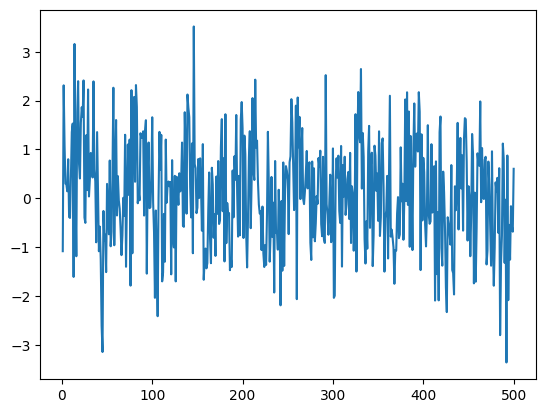

In [19]:
x, y = get_x_y()
plt.plot(x,y)


In [4]:
def get_exp_mov_averange(alpha, x, y):
    arr = [(y[0]+y[1])/2]
    for i in range(1,len(y)):
        new_val = alpha*y[i] + (1-alpha)*arr[i-1]
        arr.append(new_val)
    return arr


In [6]:
alpha = 0.1
x,y = get_x_y()
arr = get_exp_mov_averange(alpha, x, y)

In [7]:
# x,y = get_x_y()
fig = go.Figure()
fig.add_trace(go.Scatter(x=x, y=y, mode='markers', name='Dots'))
fig.add_trace(go.Scatter(x=x, y=get_real_trend(), name=f'real trend'))
for alpha in [0.01, 0.05, 0.1, 0.3]:
    fig.add_trace(go.Scatter(x=x, y=get_exp_mov_averange(alpha, x, y), name=f'alpha = {alpha}'))

fig.update_layout(
                  title="First visualization",
                  xaxis_title="X",
                  yaxis_title="Y",)
#                   margin=dict(l=0, r=0, t=30, b=0))
fig.show()

In [8]:
#Фурье
x,y = get_x_y()
sample_size = 500
h = 0.1
forward = np.fft.fft(y)
forward = np.abs(forward[0:len(y)//2])
freq = [1/sample_size * k for k in range(sample_size)][0:sample_size//2]

# forward_sin = np.fft.fft([math.sin(h * k) for k in range(sample_size)])
# forward_sin = np.abs(forward_sin[0:len(y)//2])

print('Главная частота выборки:', freq[np.argmax(forward)])
# print('Главная частота sin:', freq[np.argmax(forward_sin)])

Главная частота выборки: 0.016
Главная частота sin: 0.016


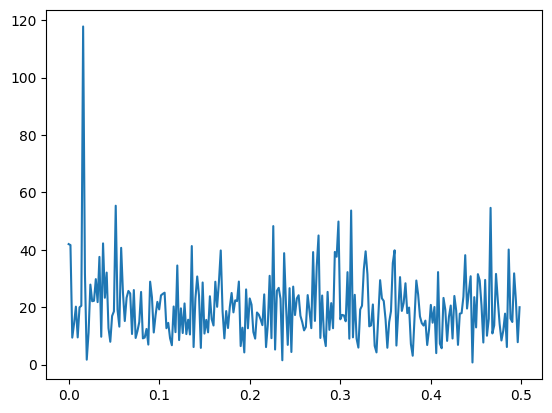

In [9]:
plt.plot(freq, forward)

In [10]:
def get_noise(alpha,x,y):
#     x,y = get_x_y()
    arr = get_exp_mov_averange(alpha,x,y)
    noise = y - arr
    return noise

In [11]:
def countof_turningpoints(lst, *args):
    dx = np.diff(lst,axis=0)
    return np.sum(dx[1:] * dx[:-1] < 0)

In [12]:
def create_samples(n,function):
    dict_ = {0.01:[], 0.05:[], 0.1:[], 0.3:[]}
    for alpha in [0.01, 0.05, 0.1, 0.3]:
        for i in range(n):
            x,y = get_x_y()
            noise = get_noise(alpha, x, y)
            dict_[alpha].append(function(noise, alpha, x, y))
    return dict_, n

In [13]:
# x,y = get_x_y()
dict_, n = create_samples(20,countof_turningpoints)
dispersion_turning_points = sqrt((16*500 - 29)/500)
def get_accident_graph(dispersion, dict_, y_, name):
    fig = go.Figure()
    fig.add_shape(type='line',
                        x0=0,
                        y0=y_ + dispersion,
                        x1=n,
                        y1=y_ + dispersion,
                        line=dict(color='Black',),
                        xref='x',
                        yref='y'
                     )
    fig.add_shape(type='line',
                    x0=0,
                    y0=y_ - dispersion,
                    x1=n,
                    y1=y_ - dispersion,
                    line=dict(color='Black',),
                    xref='x',
                    yref='y'
                 )
    for num, alpha in enumerate(dict_.keys()):
        fig.add_trace(go.Scatter(x=list(range(n)), y=dict_[alpha], mode ='markers', name=f'{alpha}'))

    fig.update_layout(
                      title=name,
                      xaxis_title="X",
                      yaxis_title="Y",)
    #                   margin=dict(l=0, r=0, t=30, b=0))
    fig.show()

get_accident_graph(dispersion_turning_points, dict_, y_=333.3, name = 'Turning points')

In [14]:
def count_P(arr):
    count = 0
    for i in range(len(arr)):
        for j in range(i):
            if arr[i] > arr[j]:
                count +=1
    return count

def get_Kendal(noise, alpha, x, y):
    n = 500
#     x,y= get_x_y()
#     noise = get_noise(alpha, x, y)
    P = count_P(noise)
    return 4*P/(n*(n-1)) -1

def get_dispersion_Kendal(n =500):
    return sqrt(2*(2*n+5)/(9*n*(n-1)))

In [15]:
dict_, n = create_samples(20,get_Kendal)
get_accident_graph(get_dispersion_Kendal(), dict_, y_=0, name = 'Кендал')

In [16]:
def get_norm_check(alpha, x,y):
    noise = get_noise(alpha, x, y)
    shapiro_ = (shapiro(noise))
    ktest_ = (kstest(noise, 'norm'))
    return shapiro_ , ktest_

In [23]:
x,y = get_x_y()
get_norm_check(0.01, x, y)
# если pvalue < 0.05 то нормально

(ShapiroResult(statistic=0.9959771037101746, pvalue=0.23354515433311462),
 KstestResult(statistic=0.12224185299389378, pvalue=5.714392875402136e-07, statistic_location=0.279949441849544, statistic_sign=-1))

In [17]:
#На Пуассоне не ошибается
print(kstest(get_poisson(), 'norm'))

KstestResult(statistic=0.9172498680518208, pvalue=1.200311317837126e-108, statistic_location=2, statistic_sign=-1)
